<a href="https://colab.research.google.com/github/Sentiago22/ISIT2024/blob/main/%D0%98%D0%A1%D0%B8%D0%A2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Шаги:**

Шаг 1: Загрузка и предварительная обработка данных

Шаг 2: Реализация метода K-ближайших соседей (KNN)

Шаг 3: Разделение данных на обучающую и тестовую выборки

Шаг 4: Оценка модели и поиск оптимального значения k

Шаг 5: Построение матрицы ошибок и расчет метрик

Шаг 6: Заключение


**Шаг 1: Загрузка и предварительная обработка данных**

На этом шаге мы загружаем данные, выбираем необходимые столбцы и преобразуем категориальные данные в числовой формат.

In [5]:
import pandas as pd

# Загрузка данных из Excel-файла
file_path = 'my_data.xlsx'
df = pd.read_excel(file_path)


In [9]:
df.head()

,Ваш пол,Возраст,Характер,Что вы предпочитаете?,Как часто вы берете инициативу в свои руки?,Как часто вы берете инициативу в свои руки? / Баллы,Как часто вы пропускаете завтраки?,Как часто вы пропускаете завтраки? / Баллы,Сколько спите ночью в среднем,Гипертония,...,Любимое время года?,Любимое время года? / Баллы,Что пьют родители,Что пьют родители / Баллы,Какие напитки любите,Какие напитки любите / Баллы,Азартен?,Набрано баллов,Всего баллов,Результат теста
0,Женский,22,Холерик,Кофе,Периодически,NaN,Очень часто,NaN,10,Нет,...,Весна,NaN,Чай и кофе,NaN,Холодные,NaN,Нет,0,0,NaN
1,Мужской,22,Холерик,Чай,Часто,NaN,Очень часто,NaN,6,Да,...,Весна,NaN,Чай,NaN,Холодные,NaN,Да,0,0,NaN
2,Мужской,22,Меланхолик,Кофе,Очень редко,NaN,Часто,NaN,6,Нет,...,Весна,NaN,Кофе,NaN,Холодные,NaN,Нет,0,0,NaN
3,Мужской,22,Флегматик,Чай,Часто,NaN,Очень редко,NaN,6,Нет,...,Лето,NaN,Чай и кофе,NaN,Холодные,NaN,Нет,0,0,NaN
4,Мужской,21,Флегматик,Чай,Часто,NaN,Редко,NaN,8,Нет,...,Осень,NaN,Чай и кофе,NaN,Горячие,NaN,Нет,0,0,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 36 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Ваш пол                                              38 non-null     object 
 1   Возраст                                              38 non-null     int64  
 2   Характер                                             38 non-null     object 
 3   Что вы предпочитаете?                                38 non-null     object 
 4   Как часто вы берете инициативу в свои руки?          38 non-null     object 
 5   Как часто вы берете инициативу в свои руки? / Баллы  0 non-null      float64
 6   Как часто вы пропускаете завтраки?                   38 non-null     object 
 7   Как часто вы пропускаете завтраки? / Баллы           0 non-null      float64
 8   Сколько спите ночью в среднем                        38 non-null     int

In [11]:
# Выбор необходимых столбцов: возраст, характер, предпочтения
df_selected = df[['Возраст', 'Характер', 'Что вы предпочитаете?']].copy()


In [13]:
# Преобразование текстовых меток в числовые значения (0: Чай, 1: Кофе)
df_selected['Что вы предпочитаете?'] = df_selected['Что вы предпочитаете?'].apply(lambda x: 0 if x == 'Чай' else 1)

In [15]:
# Преобразование 'Характер' в числовые значения
character_mapping = {
    'Холерик': 0,
    'Меланхолик': 1,
    'Флегматик': 2,
    'Сангвиник': 3
}
df_selected['Характер'] = df_selected['Характер'].map(character_mapping)

In [17]:
# Удаление строк с пропусками (если есть)
df_selected.dropna(inplace=True)

# Отобразим первые строки обработанного DataFrame
df_selected.head()

,Возраст,Характер,Что вы предпочитаете?
0,22,0,1
1,22,0,0
2,22,1,1
3,22,2,0
4,21,2,0


**Шаг 2: Реализация метода K-ближайших соседей (KNN)**

Здесь мы реализуем две функции: одну для вычисления расстояния между точками, и вторую для предсказания метки на основе K-ближайших соседей.

In [20]:
import numpy as np

# Функция для вычисления евклидова расстояния между двумя точками
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Функция для предсказания с использованием KNN
def knn_predict(training_data, training_labels, test_point, k):
    distances = []

    # Вычисление расстояния между тестовой точкой и всеми точками обучающей выборки
    for i in range(len(training_data)):
        distance = euclidean_distance(training_data[i], test_point)
        distances.append((distance, training_labels[i]))

    # Сортировка списка по расстоянию
    distances.sort(key=lambda x: x[0])

    # Выбор k ближайших соседей
    nearest_neighbors = distances[:k]

    # Голосование за метку
    votes = [neighbor[1] for neighbor in nearest_neighbors]

    # Определение предсказанной метки
    prediction = max(set(votes), key=votes.count)
    return prediction


**Шаг 3: Разделение данных на обучающую и тестовую выборки**

Здесь мы делим данные на обучающую (80%) и тестовую (20%) выборки вручную для оценки модели.


In [23]:
# Подготовка данных для обучения и тестирования
data_values = df_selected[['Возраст', 'Характер']].values
labels = df_selected['Что вы предпочитаете?'].values

# Разделение данных (80% - обучение, 20% - тест)
train_size = int(0.8 * len(data_values))
X_train, X_test = data_values[:train_size], data_values[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

**Шаг 4: Оценка модели и поиск оптимального значения k**


Точность при k=1: 0.5
Точность при k=2: 0.5
Точность при k=3: 0.625
Точность при k=4: 0.5
Точность при k=5: 0.5
Точность при k=6: 0.5
Точность при k=7: 0.375
Точность при k=8: 0.5
Точность при k=9: 0.5
Точность при k=10: 0.625
Точность при k=11: 0.5
Точность при k=12: 0.625
Оптимальное значение k: 3 с точностью: 0.625


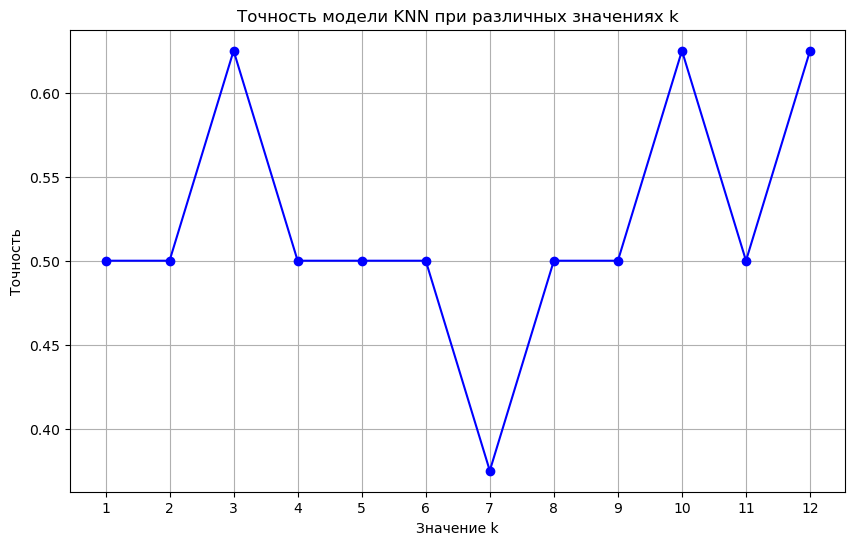

In [28]:
import matplotlib.pyplot as plt

# Функция для оценки точности модели KNN
def evaluate_knn(k):
    correct_predictions = 0

    # Предсказание для каждой точки в тестовой выборке
    for i in range(len(X_test)):
        prediction = knn_predict(X_train, y_train, X_test[i], k)
        if prediction == y_test[i]:
            correct_predictions += 1

    # Вычисление точности
    accuracy = correct_predictions / len(X_test)
    return accuracy

# Поиск оптимального значения k (от 1 до 12) и сбор данных для графика
best_k = 1
best_accuracy = 0
accuracies = []

for k in range(1, 13):
    accuracy = evaluate_knn(k)
    accuracies.append(accuracy)
    print(f"Точность при k={k}: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"Оптимальное значение k: {best_k} с точностью: {best_accuracy}")

# Визуализация графика точности для разных значений k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 13), accuracies, marker='o', linestyle='-', color='b')
plt.title('Точность модели KNN при различных значениях k')
plt.xlabel('Значение k')
plt.ylabel('Точность')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


После анализа графика и выводов кода, оптимальное значение в данном случае — k=3. Это значение выбирается, потому что оно обеспечивает наилучшую точность модели на тестовой выборке.
Таким образом, выбираем k=3, так как оно обеспечивает максимальную точность в данном наборе данных. При равной точности k =10, k =12, наименьшее значение k считается лучшим выбором, так как оно делает модель более гибкой, простой, и быстродействующей.

**Шаг 5: Построение матрицы ошибок и расчет метрик**

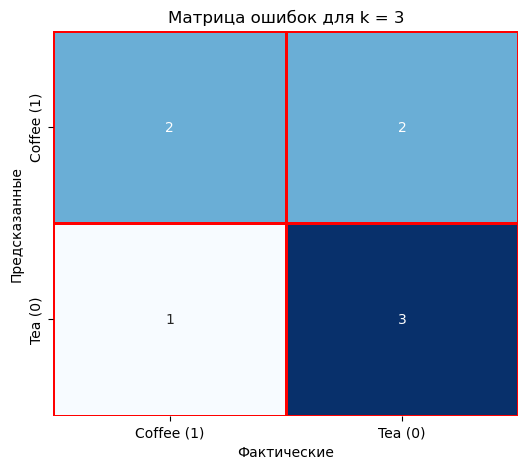

              Precision    Recall  F1-score  Support
Coffee (1)      0.50000  0.666667  0.571429      3.0
Tea (0)         0.75000  0.600000  0.666667      5.0
accuracy        0.62500  0.625000  0.625000      8.0
macro avg       0.62500  0.633333  0.619048      8.0
weighted avg    0.65625  0.625000  0.630952      8.0


In [32]:
# Импорт необходимых модулей
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Функция для построения матрицы ошибок
def confusion_matrix_knn(k):
    TP = 0  # True Positive
    TN = 0  # True Negative
    FP = 0  # False Positive
    FN = 0  # False Negative

    # Подсчет значений для матрицы ошибок
    for i in range(len(X_test)):
        prediction = knn_predict(X_train, y_train, X_test[i], k)
        actual = y_test[i]

        if prediction == 1 and actual == 1:
            TP += 1  # Истинно положительные
        elif prediction == 0 and actual == 0:
            TN += 1  # Истинно отрицательные
        elif prediction == 1 and actual == 0:
            FP += 1  # Ложно положительные
        elif prediction == 0 and actual == 1:
            FN += 1  # Ложно отрицательные

    # Создание матрицы ошибок
    confusion_matrix = np.array([[TP, FP],
                                 [FN, TN]])
    return confusion_matrix

# Функция для расчета метрик Precision, Recall, F1-score и Support с обновленными именами классов
def calculate_metrics_with_names(conf_matrix):
    TP = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TN = conf_matrix[1, 1]

    # Precision, Recall, и F1-score для класса "Coffee" (1)
    precision_coffee = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall_coffee = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_coffee = 2 * (precision_coffee * recall_coffee) / (precision_coffee + recall_coffee) if (precision_coffee + recall_coffee) != 0 else 0
    support_coffee = TP + FN

    # Precision, Recall, и F1-score для класса "Tea" (0)
    precision_tea = TN / (TN + FN) if (TN + FN) != 0 else 0
    recall_tea = TN / (TN + FP) if (TN + FP) != 0 else 0
    f1_tea = 2 * (precision_tea * recall_tea) / (precision_tea + recall_tea) if (precision_tea + recall_tea) != 0 else 0
    support_tea = TN + FP

    # Сбор всех метрик в словарь
    metrics = {
        "Coffee (1)": {
            "Precision": precision_coffee,
            "Recall": recall_coffee,
            "F1-score": f1_coffee,
            "Support": support_coffee
        },
        "Tea (0)": {
            "Precision": precision_tea,
            "Recall": recall_tea,
            "F1-score": f1_tea,
            "Support": support_tea
        }
    }

    return metrics

# Функция для расчета точности (Accuracy)
def calculate_accuracy(conf_matrix):
    TP = conf_matrix[0, 0]
    TN = conf_matrix[1, 1]
    total_predictions = np.sum(conf_matrix)

    # Расчет точности
    accuracy = (TP + TN) / total_predictions
    return accuracy

# Функция для создания итоговой таблицы с добавлением accuracy, macro avg и weighted avg
def create_detailed_summary_table(metrics, accuracy):
    # Преобразование метрик в DataFrame
    metrics_df = pd.DataFrame(metrics).T

    # Расчет макро-среднего (macro avg)
    macro_avg = metrics_df[['Precision', 'Recall', 'F1-score']].mean()

    # Расчет взвешенного среднего (weighted avg)
    weighted_avg = (metrics_df[['Precision', 'Recall', 'F1-score']].mul(metrics_df['Support'], axis=0).sum() / metrics_df['Support'].sum())

    # Добавление строки с общей точностью (accuracy)
    accuracy_row = pd.Series({'Precision': accuracy, 'Recall': accuracy, 'F1-score': accuracy, 'Support': metrics_df['Support'].sum()}, name='accuracy')

    # Добавление строк для макро- и взвешенного среднего
    macro_avg_row = pd.Series({'Precision': macro_avg['Precision'],
                               'Recall': macro_avg['Recall'],
                               'F1-score': macro_avg['F1-score'],
                               'Support': metrics_df['Support'].sum()}, name='macro avg')

    weighted_avg_row = pd.Series({'Precision': weighted_avg['Precision'],
                                  'Recall': weighted_avg['Recall'],
                                  'F1-score': weighted_avg['F1-score'],
                                  'Support': metrics_df['Support'].sum()}, name='weighted avg')

    # Объединение всех строк в итоговую таблицу
    summary_df = pd.concat([metrics_df, accuracy_row.to_frame().T, macro_avg_row.to_frame().T, weighted_avg_row.to_frame().T])

    return summary_df

# Построение матрицы ошибок для оптимального k = 3
best_k = 3
# Предполагается, что X_train, y_train, X_test, y_test и knn_predict уже определены в рабочем окружении
conf_matrix = confusion_matrix_knn(best_k)

# Визуализация матрицы ошибок с обновленными именами классов
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, linecolor='red', linewidths=1)
plt.title(f'Матрица ошибок для k = {best_k}')
plt.xlabel('Фактические')
plt.ylabel('Предсказанные')
plt.xticks([0.5, 1.5], ['Coffee (1)', 'Tea (0)'])
plt.yticks([0.5, 1.5], ['Coffee (1)', 'Tea (0)'])
plt.show()

# Расчет метрик и точности
metrics = calculate_metrics_with_names(conf_matrix)
accuracy = calculate_accuracy(conf_matrix)

# Создание подробной таблицы
detailed_summary_table = create_detailed_summary_table(metrics, accuracy)

# Вывод подробной таблицы
print(detailed_summary_table)


Модель KNN с параметром k=3 показала следующие результаты:

Правильно предсказанные случаи для "Coffee": 2.
Неправильно предсказанные случаи, когда "Coffee" был классифицирован как "Tea": 2.
Правильно предсказанные случаи для "Tea": 3.
Ошибок, когда "Tea" был классифицирован как "Coffee": 1.
Замечание:
Анализ матрицы ошибок показывает, что модель имеет небольшие затруднения в классификации "Coffee", так как в 2 случаях модель ошибочно классифицировала "Coffee" как "Tea". Однако, она немного лучше справляется с классификацией "Tea", правильно предсказав 3 из 4 случаев, допуская всего 1 ошибку, когда "Tea" был классифицирован как "Coffee".

**Шаг 6: Заключение**

Модель K-ближайших соседей (KNN) с оптимальным значением
k=3 достигла умеренной производительности на данном наборе данных. Матрица ошибок, метрики precision, recall и F1-score позволяют оценить, насколько эффективно модель классифицирует два класса ("Coffee" и "Tea"). Несмотря на приемлемую точность, результаты показывают, что модель может быть улучшена, чтобы достичь лучшего баланса между точностью и полнотой. Для дальнейшего повышения эффективности можно использовать другие методы предобработки данных и альтернативные алгоритмы классификации.